# Chapter 31- ING Entrainment of E - Cells
This notebook is a translation of an example in Christophe Borgers' book, "An Introduction to Modeling Neuronal Dynamics"

In this tutorial,we display an Interneuronal Network Gamma (ING) network entrain excitatory neurons (E-cells). Gamma rhythms are 30-80 Hz, thus the firing of the E-cells must be within this range. We model 400 E-cells with an RTM model and the ING cells with a WB model.

requirements:

 bmtk

 NEURON 7.4+

### Create nodes
The ING network, E-cells, and external input nodes are defined

In [1]:
! pip install -q h5py==2.9.0
! pip install -q bmtk==0.0.9
! pip install -q neuron==8.0.0
# as new version of neuron and bmtk come out we may need to install a specific version
import os
from os.path import normpath, sep, join

root = 'Borgers-Examples-in-BMTK' # name of github repo
folder = '31-ING_Entrainment' # name of folder in Github just change this line 
pathlist = normpath(os.getcwd()).split(sep)
if pathlist[-1] != folder:
  rootidx = pathlist.index(root) if root in pathlist else -1
  if rootidx>0:
    os.chdir(join(sep,*pathlist[:rootidx]))
  !git clone https://github.com/GregGlickert/Borgers-Examples-in-BMTK
  os.chdir(join(root,folder))
print(os.getcwd())
%ls

     |████████████████████████████████| 2.8 MB 5.3 MB/s 
     |████████████████████████████████| 4.8 MB 5.4 MB/s 
     |████████████████████████████████| 12.6 MB 5.2 MB/s 
Cloning into 'Borgers-Examples-in-BMTK'...
remote: Enumerating objects: 912, done.
remote: Total 912 (delta 0), reused 0 (delta 0), pack-reused 912
Receiving objects: 100% (912/912), 31.14 MiB | 24.82 MiB/s, done.
Resolving deltas: 100% (490/490), done.
/content/Borgers-Examples-in-BMTK/31-ING_Entrainment
31_ING.ipynb  components/


In [1]:
import os
print(os.system('nrnivmodl components/mechanisms')) # compile modfiles. Return 0 for success, 1 for failure.

/usr/bin/xcrun
/Users/gregglickert/Desktop/Borgers-Examples-in-BMTK-main/31-ING_Entrainment
-n Mod files:
-n  "components/mechanisms/gap.mod"
-n  "components/mechanisms/k_rtm.mod"
-n  "components/mechanisms/k_wb.mod"
-n  "components/mechanisms/leak.mod"
-n  "components/mechanisms/na_rtm.mod"
-n  "components/mechanisms/na_wb.mod"
-n  "components/mechanisms/vecevent.mod"


Creating x86_64 directory for .o files.

COBJS=''
 -> Compiling mod_func.c
gcc -O2   -I.   -I/Users/gregglickert/opt/anaconda3/envs/NeuroLab/lib/python3.7/site-packages/neuron/.data/include  -I/usr/local/Cellar/open-mpi/4.1.0/include -fPIC -c mod_func.c -o mod_func.o
 -> NMODL ../components/mechanisms/gap.mod
 -> NMODL ../components/mechanisms/k_rtm.mod
 -> NMODL ../components/mechanisms/k_wb.mod
(cd "../components/mechanisms"; MODLUNIT=/Users/gregglickert/opt/anaconda3/envs/NeuroLab/lib/python3.7/site-packages/neuron/.data/share/nrn/lib/nrnunits.lib /Users/gregglickert/opt/anaconda3/envs/NeuroLab/lib/python3.7/site-pa

Translating k_wb.mod into /Users/gregglickert/Desktop/Borgers-Examples-in-BMTK-main/31-ING_Entrainment/x86_64/k_wb.c
Translating k_rtm.mod into /Users/gregglickert/Desktop/Borgers-Examples-in-BMTK-main/31-ING_Entrainment/x86_64/k_rtm.c
Translating gap.mod into /Users/gregglickert/Desktop/Borgers-Examples-in-BMTK-main/31-ING_Entrainment/x86_64/gap.c
Thread Safe
Thread Safe
Thread Safe
Translating leak.mod into /Users/gregglickert/Desktop/Borgers-Examples-in-BMTK-main/31-ING_Entrainment/x86_64/leak.c
Translating na_rtm.mod into /Users/gregglickert/Desktop/Borgers-Examples-in-BMTK-main/31-ING_Entrainment/x86_64/na_rtm.c
Thread Safe
Thread Safe
Translating na_wb.mod into /Users/gregglickert/Desktop/Borgers-Examples-in-BMTK-main/31-ING_Entrainment/x86_64/na_wb.c
Thread Safe
Translating vecevent.mod into /Users/gregglickert/Desktop/Borgers-Examples-in-BMTK-main/31-ING_Entrainment/x86_64/vecevent.c
Thread Safe


 -> Compiling leak.c
 -> Compiling na_rtm.c
gcc -O2   -I"../components/mechanisms" -I.   -I/Users/gregglickert/opt/anaconda3/envs/NeuroLab/lib/python3.7/site-packages/neuron/.data/include  -I/usr/local/Cellar/open-mpi/4.1.0/include -fPIC -c na_rtm.c -o na_rtm.o
gcc -O2   -I"../components/mechanisms" -I.   -I/Users/gregglickert/opt/anaconda3/envs/NeuroLab/lib/python3.7/site-packages/neuron/.data/include  -I/usr/local/Cellar/open-mpi/4.1.0/include -fPIC -c leak.c -o leak.o
 -> Compiling vecevent.c
 -> Compiling na_wb.c
gcc -O2   -I"../components/mechanisms" -I.   -I/Users/gregglickert/opt/anaconda3/envs/NeuroLab/lib/python3.7/site-packages/neuron/.data/include  -I/usr/local/Cellar/open-mpi/4.1.0/include -fPIC -c vecevent.c -o vecevent.o
gcc -O2   -I"../components/mechanisms" -I.   -I/Users/gregglickert/opt/anaconda3/envs/NeuroLab/lib/python3.7/site-packages/neuron/.data/include  -I/usr/local/Cellar/open-mpi/4.1.0/include -fPIC -c na_wb.c -o na_wb.o
 => LINKING shared library ./libnrnmech

In [2]:
import numpy as np
import logging
import math

from bmtk.builder.networks import NetworkBuilder

# E - Cells
n_E = 400

net = NetworkBuilder('network')
net.add_nodes(N=n_E, pop_name='Exc',     # N = number of excitatory cells
        model_type='biophysical',
        model_template='hoc:RTMExcCell', # RTMExcCell hoc definition
        morphology='blank.swc')

# ING network
n_I = 100

net.add_nodes(N=n_I, pop_name='ING',     # N = number of ING cells
        model_type='biophysical',
        model_template='hoc:WBInhCell', 
        morphology='blank.swc')

### Connection rules 

We add connections based on a probability defined below. To prevent autapses, if the node_id is equal between source and targe cell, no connection is made.

In [3]:
import random

def syn_connector(source,target,p):
    if source['node_id'] == target['node_id']:
        return 0
    return 1 if random.random() < p else 0

### Creating ING Edges

Probabilities and conductances are taken from chapter 31 of Borgers' book. Inhibitory connections between ING cells are added; Inhibitory connections from ING cells to E - cells are added; gap juctions between ING cells are added.

In [4]:
g_ee = 0
g_ei = 0
g_ie = 0.5  #0.5
g_ii = 0.5  #0.5
g_gap = 0.1

p_gap = 0.05
p_ee = 1
p_ei = 0.5
p_ie = 0.5  # 0.5
p_ii = 0.5   # 0.5



#E-E connections dont exist (g_ee = 0)
         
#E-I connections dont exist (g_ei = 0)

#I-I connections
net.add_edges(source={'pop_name':'ING'}, target={'pop_name':'ING'},
                    connection_rule=syn_connector, 
                    connection_params={'p':p_ii},
                    delay=0,
                    syn_weight = g_ii/n_I,
                    weight_function=None,
                    target_sections=['soma'],
                    distance_range=[0.0, 0.1],
                    dynamics_params='PING_InhToInh.json',
                    model_template='Exp2Syn')
                    
#I-E connections
net.add_edges(source={'pop_name':'ING'}, target={'pop_name':'Exc'},
                    connection_rule=syn_connector,
                    connection_params={'p':p_ie},
                    delay=0,
                    syn_weight = g_ie/n_I,
                    weight_function=None,
                    target_sections=['soma'],
                    distance_range=[0.0, 0.1],
                    dynamics_params='PING_InhToExc.json',
                    model_template='Exp2Syn')

#gap junctions
net.add_edges(source={'pop_name':'ING'}, target={'pop_name':'ING'}, 
                      syn_weight=g_gap,
                      weight_function=None,
                      target_sections=['soma'],
                      model_template='Gap',
                      delay=0,
                      distance_range=[0.0, 0.1],
                      is_gap_junction=True,
                      connection_rule=syn_connector, 
                      connection_params={'p':p_gap})

In [5]:
net.build()
net.save_nodes(output_dir='network')
net.save_edges(output_dir='network')

In [6]:
from bmtk.builder.networks import NetworkBuilder

extnet = NetworkBuilder('extnet')

extnet.add_nodes(N=n_E, model_type='virtual', pop_name='bgnoisevirtExt', pop_group='bgnoisevirtExt')

### Current Clamps for E-Cells and ING network

In [7]:
import h5py
import os

try:
  os.isdir('input')
except:
  os.makedirs('input')

I_bar_E = 1.5      #1.5
sigma_E = 0.1   #0.1
I_bar_I = 1.5      #1.5
sigma_I = 0.5   #0.5


n_I = 100
n_E = 400
sim_len = 500
dt = 1
samples = int(sim_len/dt)
amp = np.zeros((n_E+n_I,samples))


amp[n_I:,:] = (I_bar_E * (1 + sigma_E*np.random.normal(size=n_E))).reshape(-1,1) # Excitatory Cell Current Injection
amp[:n_I,:] = (I_bar_I * (1 + sigma_I*np.random.normal(size=n_I))).reshape(-1,1) # Inhibitory Cell Current Injection


dts = [1]
gids = "all"

#hf.close() # Uncomment this line temporarily if you receive 'file already open error'

hf = h5py.File("input/amps.h5", 'w')

hf.create_dataset("amplitudes", data=[amp])
hf.create_dataset("gids", data=gids)
hf.create_dataset("dts", data=dts)

hf.close()

### Set up Simulation Environment

In [8]:
from bmtk.utils.sim_setup import build_env_bionet

build_env_bionet(base_dir='.',
                 network_dir='network',
                 tstop=500.0, dt=0.1,
                 report_vars=['v'],           # Record membrane potential and calcium (default soma)
                 #spikes_inputs=[('extnet',   # Name of population which spikes will be generated for
                                #'input/ext_inp_poisson.h5')],
                 #file_current_clamp={              
                      #"input_type": "file_current_clamp",
                      #"module": "FileIClamp",
                      #"input_file":"input/amps.h5",
                      #"node_set":"all"
                 #},
                  current_clamp={            # Creates a step current from 500.ms to 1500.0 ms
                    'amp': 0.400,
                    'delay': 0,
                    'duration': 30.0
                  },
                 v_init= -65,
                 include_examples=False,    # Copies components files
                 compile_mechanisms=False,   # Will try to compile NEURON mechanisms
                 config_file ='config.json'
                )

### Run the Simulation

In [9]:
from bmtk.simulator import bionet


conf = bionet.Config.from_json('config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

numprocs=1
2022-10-03 21:50:14,612 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


NEURON mechanisms not found in /Users/gregglickert/Desktop/Borgers-Examples-in-BMTK-main/31-ING_Entrainment/components/mechanisms.
2022-10-03 21:50:14,731 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2022-10-03 21:50:15,366 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2022-10-03 21:50:57,838 [INFO] Running simulation for 500.000 ms with the time step 0.100 ms


INFO:NEURONIOUtils:Running simulation for 500.000 ms with the time step 0.100 ms


2022-10-03 21:50:57,840 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2022-10-03 21:50:57,841 [INFO] Block save every 5000 steps


INFO:NEURONIOUtils:Block save every 5000 steps


2022-10-03 21:51:45,028 [INFO]     step:5000 t_sim:500.00 ms


INFO:NEURONIOUtils:    step:5000 t_sim:500.00 ms


2022-10-03 21:51:45,183 [INFO] Simulation completed in 47.34 seconds 


INFO:NEURONIOUtils:Simulation completed in 47.34 seconds 


### Analyze Results

We did not add initial voltage values to the ING network nor the E - cells. Because of a synchronous initialization, only the ING cell entrainment of the E-cells can be observed. The E - cells are already synchronous.

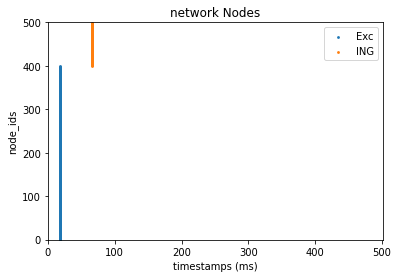

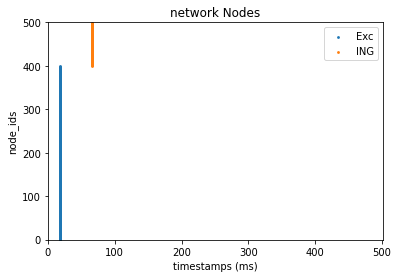

In [10]:
from bmtk.analyzer.spike_trains import plot_raster,plot_rates_boxplot

plot_raster(config_file='config.json', with_histogram=False, population='network', group_by='pop_name')

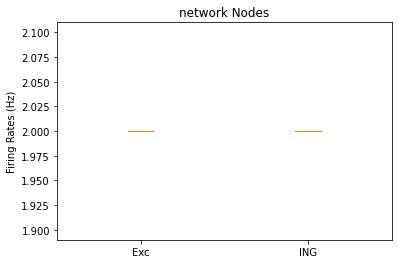

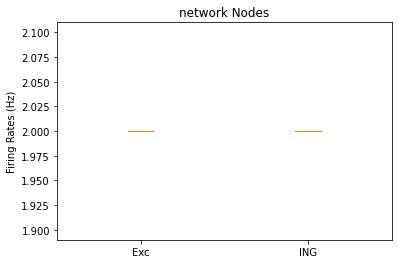

In [11]:
plot_rates_boxplot(config_file='config.json', group_by='pop_name')

The ING network successfully entrained the E-cells (Exc) at ~30 Hz which is in Gamma wave range